<a href="https://colab.research.google.com/github/casalazara/Machine-Learning-IELE/blob/master/Reto%204/Reto4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd 
from keras.preprocessing import image
from keras.models import load_model
from google.colab import drive

In [10]:
drive.mount('./gdrive')
os.chdir('./gdrive/MyDrive/reto4')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory="seg_train",target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory="seg_test", target_size=(224,224))

# VGG-16
![Arquitectura](https://miro.medium.com/max/850/1*_Lg1i7wv1pLpzp2F4MLrvw.png)


## Callback

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, weights_dir, patience=10, rate=0.5):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        """
        self.best_loss = np.Inf
        self.best_acc = 0
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :param logs: The logs from the output from an epoch ended
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        # Current validation Accuracy
        current_acc = logs.get("val_acc")
        if (current_loss < self.best_loss and 
            current_acc > self.best_acc):
            # We save the model weights
            # We wait again
            # We assign the best loss and the best accuracy.
            self.wait = 0
            self.best_loss = current_loss
            self.best_acc = current_acc
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")

## Sin Transfer Learning

### Construcción del modelo

In [ ]:
model = Sequential([
                    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                    Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2)),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
                    MaxPool2D(pool_size=(2,2),strides=(2,2))
])

### Últimas capas

In [ ]:
model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=64,activation="relu"))
model.add(Dense(units=6, activation="softmax"))

### Compilación

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

### Resumen del modelo

In [ ]:
model.summary()

### Entrenamiento

In [ ]:
history = model.fit_generator(steps_per_epoch=100,
                              generator=traindata, validation_data= testdata, 
                              validation_steps=10,epochs=100,
                              callbacks=[CustomCallback('train_best_weights_1.h5')])

### Evaluación

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Con Transfer Learning

### Carga del modelo

In [ ]:
model=VGG16(include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 0s 0us/step


### Congelamiento de capas

In [ ]:
for layer in model.layers:
    layer.trainable=False

### Últimas capas

In [ ]:
output=model.layers[-1].output
model_final=tf.keras.layers.Flatten()(output)
model_final=tf.keras.layers.Dense(512,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(64,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(6,activation='softmax')(model_final)

### Modelo final

In [ ]:
model=tf.keras.models.Model(model.input,model_final)

### Compilación

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

### Resumen del modelo

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

### Entrenamiento

In [ ]:
history = model.fit_generator(steps_per_epoch=100,
                              generator=traindata, validation_data= testdata, 
                              validation_steps=10,epochs=100,
                              callbacks=[CustomCallback('train_best_weights_2.h5')])

Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 0.1371 - acc: 0.9517
Best Weights Saved!!
150/150 [==============================] - 1190s 8s/step - loss: 0.1371 - acc: 0.9517 - val_loss: 0.3291 - val_acc: 0.8933
Epoch 2/5
150/150 [==============================] - 1196s 8s/step - loss: 0.1165 - acc: 0.9575 - val_loss: 0.5077 - val_acc: 0.8267
Epoch 3/5
150/150 [==============================] - 1195s 8s/step - loss: 0.0865 - acc: 0.9708 - val_loss: 0.3219 - val_acc: 0.8867
Epoch 4/5
150/150 [==============================] - 1194s 8s/step - loss: 0.0444 - acc: 0.9883 - val_loss: 0.4785 - val_acc: 0.8533
Epoch 5/5
150/150 [==============================] - 1196s 8s/step - loss: 0.0252 - acc: 0.9958 - val_loss: 0.3314 - val_acc: 0.8867


### Evaluación

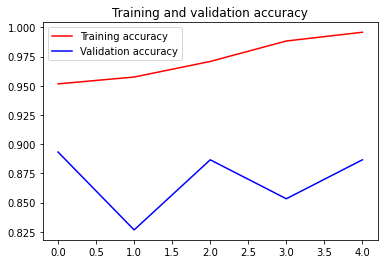

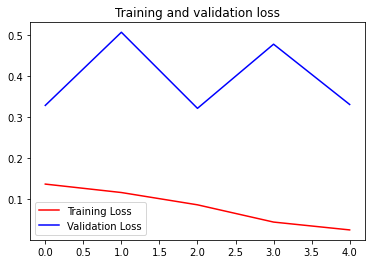

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()